# Detection and Classification of Thoractic Diseases on NIH-Chest-Xray14 Dataset

***


<u>**Contents**</u>

1. Datasets
2. Preprocessing
    - Data Preprocessing
    - Image Preprocessing
3. Image Generator and Loader
4. Model
5. Training
6. Evaluation

***


![](./assets/Male-thorax-region.png)

[[Img: Male Thorax Region @](https://www.researchgate.net/figure/Male-thorax-region_fig6_40686893)]

**In Case of Colab : To Mount Google Drive @Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd '/content/drive/My Drive/Colab/'

In [ ]:
!ls

***

### Libraries, Tools (Data Manipulation, Algebraic Computation, and Visualization)

In [26]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

## 1. Datasets

***

[[**Source@**](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)]


This NIH Chest X-ray8 Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be **>90% accurate** and suitable for weakly-supervised learning. [[More@](https://arxiv.org/abs/1705.02315)]

### Instruction

- [[**Download@**](https://nihcc.app.box.com/v/ChestXray-NIHCC)] | `python Utils/download.py` to download Images($ \approx 45GB $)

- Create `/Datasets/images/`, Extract the compressed files inside images directory.
- Directory tree:

```bash
./Datasets/
    - img_raw/
        - images_001/<images-here>
        - images_002/<images-here>
        - images_003/<images-here>
        - images_004/<images-here>
        - images_005/<images-here>
        - images_006/<images-here>
        - images_007/<images-here>
        - images_008/<images-here>
        - images_009/<images-here>
        - images_010/<images-here>
        - images_011/<images-here>
        - images_012/<images-here>
    - preprocessing.py

```

    
### Dataset Information Available

1. **Boundary box dataset provided by NIH (not used for our task)** Relevant for localization of anomalies.

2. **Main dataset information with disease information (used in this notebook)**

In [94]:
bbox_df = pd.read_csv('./Datasets/BBox_List_2017.csv')
print('Shape :',bbox_df.shape)
bbox_df.head(3)

Shape : (984, 9)


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN


In [95]:
full_df = pd.read_csv('./Datasets/Data_Entry_2017.csv')
print(f'Shape : {full_df.shape} \n')
full_df.head(3)

Shape : (112120, 12) 



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


`Data_Entry_2017.csv`

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:
- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
- Nodule Mass
- Hernia

## 2. Preprocessing
***

- 2.1 Data Preprocessing
- 2.2 Image Preprocessing


### 2.1 Data Preprocessing

#### Initial Dataframe

In [96]:
full_df = pd.read_csv('./Datasets/Data_Entry_2017.csv')
full_df = full_df.drop(columns=['Follow-up #','OriginalImage[Width', 'Height]','OriginalImagePixelSpacing[x','y]','Unnamed: 11'])

print(f'Shape : {full_df.shape} \n')
full_df.head()

Shape : (112120, 6) 



,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA
3,00000002_000.png,No Finding,2,81,M,PA
4,00000003_000.png,Hernia,3,81,F,PA


#### Unique labels counts in `Finding Labels` and Distribution (Barplot)

In [97]:
# Number of unique labels in column Finding Labels
labels_col = full_df['Finding Labels']

# No. of unique labels
n_uniq_labels = labels_col.nunique()
print('Number of unique labels:',n_uniq_labels)

# Frequency (counts per label)
count_uniq_label = labels_col.value_counts()

# Unique Labels to Dataframe
df_count_uniq_label = count_uniq_label.to_frame()
df_count_uniq_label.head(20)

Number of unique labels: 836


,Finding Labels
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
Pneumothorax,2194
Mass,2139
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350
Consolidation,1310


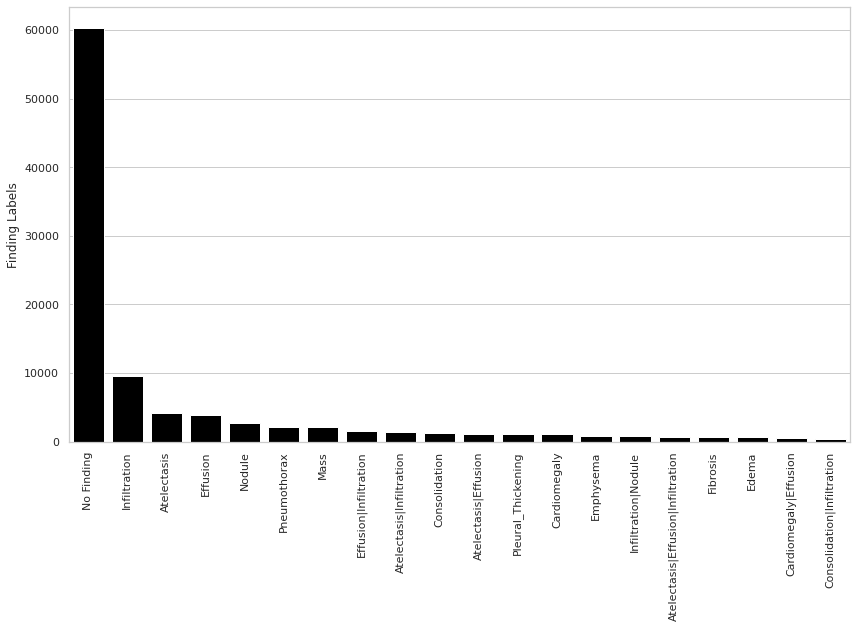

In [98]:
# Barplot
uniq_labels = df_count_uniq_label.index[:20]
count_uniq_labels = df_count_uniq_label[:20]

fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.set_style("whitegrid")
sns.barplot(x=uniq_labels, y="Finding Labels", data=count_uniq_labels, color = "black"), plt.xticks(rotation = 90);

#### Label encoding of diseases to Dataframe

In [99]:
from itertools import chain

# labels = ['Atelectasis'
#           , 'Consolidation'
#           , 'Infiltration'
#           , 'Pneumothorax'
#           , 'Edema'
#           , 'Emphysema'
#           , 'Fibrosis'
#           , 'Effusion'
#           , 'Pneumonia'
#           , 'Pleural_Thickening'
#           , 'Cardiomegaly'
#           , 'Nodule'
#           , 'Mass'
#           , 'Hernia']

# for label in labels:
#     full_df[label] = full_df['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
    

full_df['Finding Labels'] = full_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

labels = np.unique(list(chain(*full_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

labels = [x for x in labels if len(x)>0]
print(labels)

# print('All Labels ({}): {}'.format(len(labels), labels))

for clean_label in labels:
    if len(clean_label)>1: # leave out empty labels
        full_df[clean_label] = full_df['Finding Labels'].map(lambda finding: 1.0 if clean_label in finding else 0)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [100]:
full_df.head(3)

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,1,58,M,PA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Distribution of clean labels ( without Normal cases)

In [101]:
# Excluding No-Findings number of cases present for each of 14 classes.
# Sorted value_count for clean labels

clean_labels = full_df[labels].sum().sort_values()

df_clean_labels_count = clean_labels.to_frame()
df_clean_labels_count.head(-1)

,0
Hernia,227.0
Pneumonia,1431.0
Fibrosis,1686.0
Edema,2303.0
Emphysema,2516.0
Cardiomegaly,2776.0
Pleural_Thickening,3385.0
Consolidation,4667.0
Pneumothorax,5302.0
Mass,5782.0


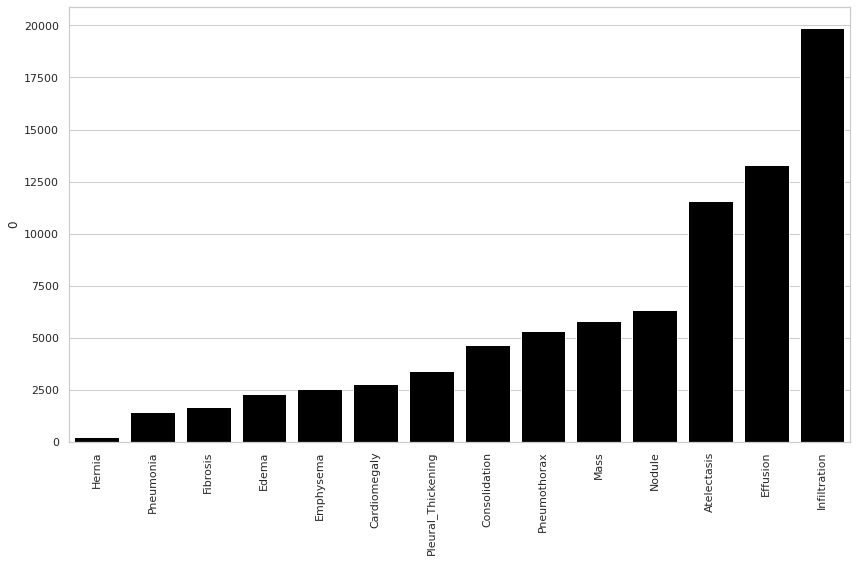

In [102]:
# Plot
clean_labels_idx = df_clean_labels_count.index[::]
clean_labels = df_clean_labels_count[::]

fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.set_style("whitegrid")
sns.barplot(x = clean_labels_idx, y=0, data = clean_labels[::], color = "black"), plt.xticks(rotation = 90);

#### Relative path of images to Dataframe

In [103]:
# The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
from glob import glob

# List of full image paths
my_glob = glob('./Datasets/dataset_original/*/*.png')

# img_paths to dataframe
img_paths = {os.path.basename(x): x for x in my_glob}
full_df['img_paths'] = full_df['Image Index'].map(img_paths.get)


print(f'Number of Images:  {len(my_glob)}\n')
full_df.head(5)

Number of Images:  112120



,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_paths
0,00000001_000.png,Cardiomegaly,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...
3,00000002_000.png,,2,81,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...
4,00000003_000.png,Hernia,3,81,F,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...


#### Ground truth (Target vector) to Dataframe

In [104]:
# create vector as ground-truth, will use as actuals to compare against our predictions later
full_df['target_vector'] = full_df.apply(lambda target: [target[labels].values], 1).map(lambda target: target[0])
full_df.head(5)

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_paths,target_vector
0,00000001_000.png,Cardiomegaly,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M,PA,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,,2,81,M,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,3,81,F,PA,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


#### Unique Patient ID

In [105]:
print('------------------------------------------------------------')
print('Total Patient IDs :', full_df['Patient ID'].count())
print('Unique Patient IDs :', full_df['Patient ID'].value_counts().shape[0])
print('------------------------------------------------------------')

------------------------------------------------------------
Total Patient IDs : 112120
Unique Patient IDs : 30805
------------------------------------------------------------


#### Clean dataframe: `xray_df` : for Loader and Generator

In [106]:
xray_df = full_df.drop(columns=['Finding Labels','Patient Age', 'Patient Gender','View Position'])
print(xray_df.shape)
xray_df.head(3)

(112120, 18)


,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_paths,target_vector
0,00000001_000.png,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/dataset_original/images_001/0000000...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


### 2.2 Image Preprocessing

-  Resize images to (256x256)
-  Increase of exposure using Contrast Limited Adaptive Histogram Equalization (CLAHE).


**Before: (1028 x 1024)**

![](./assets/before.jpg)

**After: (256 x 256)**

![](./assets/after.jpg)

*Both image above rescaled to (250 x 250) for visualization*

**Run Once ( before Runtime )**

Since the kernel will be busy running this cell for a while, it is recommended to use terminal `python Datasets/preprocessing.py` instead. The cell below needs to be modified to read `xray_df` to get `img_paths`


In [107]:
%%writefile ./Datasets/preprocessing.py
#-------------------------------------------------------------------------------------------------------------
# Resize and CLAHE to Images | (CPU Time : 2.5 hours on [Intel i7-9750H (12) @ 2.600GHz])  
#-------------------------------------------------------------------------------------------------------------

from glob import glob
from skimage import exposure, transform, color

img_shape = (256,256)

# Dictionary with key = img_name and value = 'full path'
img_paths = np.hstack(xray_df['img_paths'].values)
print(img_paths.shape)

path_list = os.listdir('./Datasets/img_raw/')
print(path_list)
for dirs in path_list:
    os.makedirs(f'./Datasets/xray_preprocessed/{dirs}', exist_ok=True)

    
#------------------------------------------- Image Processing ----------------------------------------------
i=0
for img_path in img_paths :
    i += 1
    
    # print no. of sample after every processed 1000
    if  i % max(1, int(len(img_paths)/1000))==0: print(i, '/', len(img_paths))
        
    # save processed images to xray_preprocessed
    new_path = img_path.replace('img_raw', 'xray_preprocessed')
    img = plt.imread(img_path)
    img = color.rgb2gray(img)
    
    # Increase Exposure with CLAHE
    img = exposure.equalize_adapthist(img, clip_limit=0.05)
    
    # Resize Image to img_shape
    img = transform.resize(img, img_shape, anti_aliasing=True)
    plt.imsave(fname=new_path, arr=img, cmap='gray')
    
print('>>> -------------------------- Processing Complete -------------------------- <<< ')
#-------------------------------------------------------------------------------------------------------------

Overwriting ./Datasets/preprocessing.py


#### Replace original image path with Processed Images path to Dataframe

In [108]:
# The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
from glob import glob

# List of full image paths
my_glob = glob('./Datasets/xray_preprocessed/*/*.png')

# img_paths to dataframe
img_paths = {os.path.basename(x): x for x in my_glob}
xray_df['img_paths'] = xray_df['Image Index'].map(img_paths.get)


print(f'Number of Images:  {len(my_glob)}\n')
xray_df.head(5)

Number of Images:  112120



,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_paths,target_vector
0,00000001_000.png,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


### Image Samples (Before Processing)

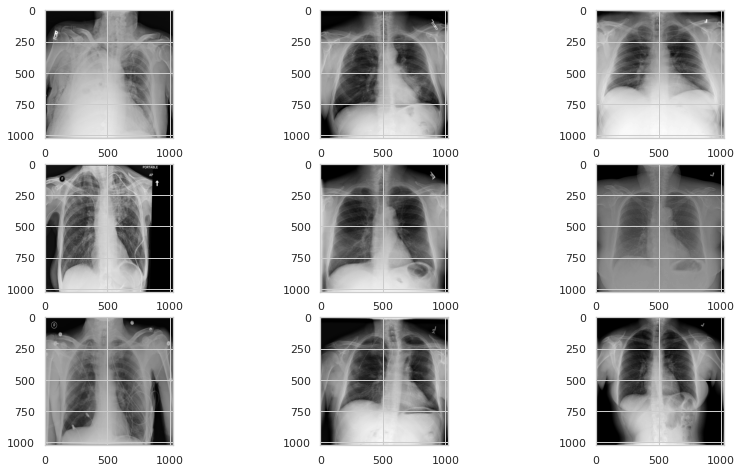

In [109]:
# Dataframe : numpy values from Image column
path_col = full_df['img_paths']

images = path_col.values
rand_img = [np.random.choice(images) for i in range(9)]

# Plot 9 random images

fig = plt.gcf()
fig.set_size_inches(14, 8)

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(rand_img[i])
    plt.imshow(img, cmap='gray')

#### Single sample

Img. Dimension:  (1024, 1024)
Max, Min Pixel values (0.9882353, 0.0)
Mean, SD of Pixel values (0.38427958, 0.26080754)


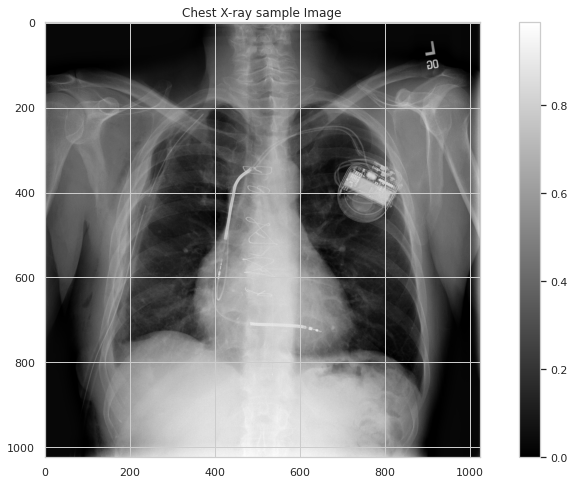

In [110]:
sample_img = plt.imread(path_col[77])
# print(path_col[33])

fig = plt.gcf()
fig.set_size_inches(14, 8)

plt.title('Chest X-ray sample Image')
plt.imshow(sample_img, cmap='gray')
plt.colorbar()

print('Img. Dimension: ', sample_img.shape)
print('Max, Min Pixel values',( sample_img.max(), sample_img.min()))
print('Mean, SD of Pixel values', (sample_img.mean(), sample_img.std()))

#### Histogram of Pixel distribution

Text(0, 0.5, 'no. of pixels in image')

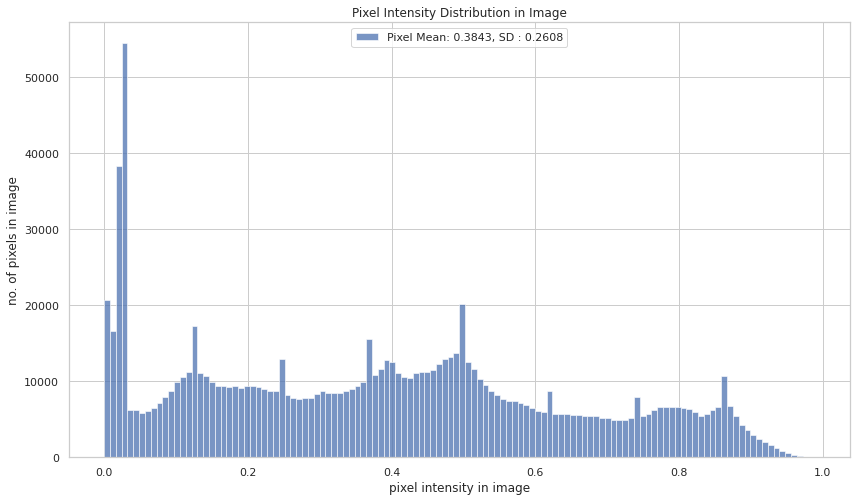

In [111]:
fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.histplot(
    sample_img.ravel()
    , label = f'Pixel Mean: {np.mean(sample_img):.4f}, SD : {np.std(sample_img):.4f}'
    , kde=False )

plt.legend(loc='upper center')
plt.title('Pixel Intensity Distribution in Image')
plt.xlabel('pixel intensity in image')
plt.ylabel('no. of pixels in image')

### Image Samples (After Processing)

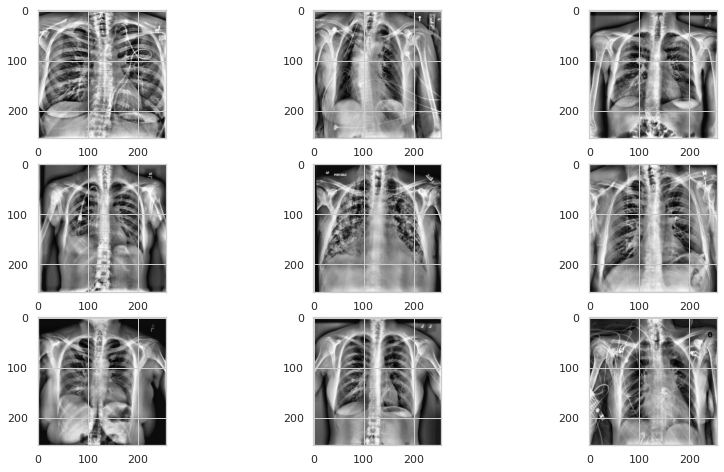

In [115]:
# Dataframe : numpy values from Image column
path_col = xray_df['img_paths']

images = path_col.values
rand_img = [np.random.choice(images) for i in range(9)]

# Plot 9 random images

fig = plt.gcf()
fig.set_size_inches(14, 8)

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(rand_img[i])
    plt.imshow(img, cmap='gray')

#### Single Processed Sample

Img. Dimension:  (256, 256, 4)
Max, Min Pixel values (1.0, 0.0)
Mean, SD of Pixel values (0.6092306, 0.30112132)


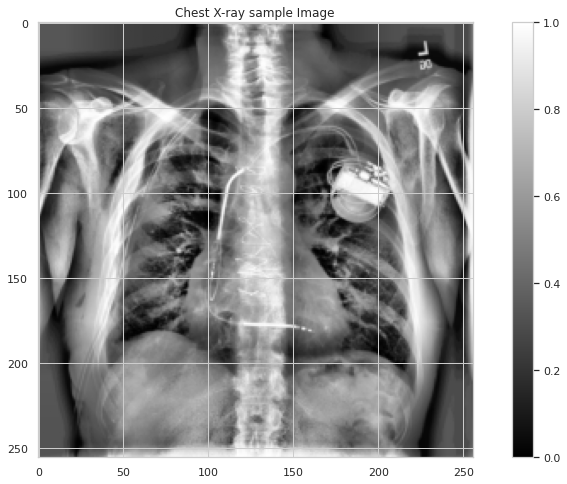

In [116]:
sample_img = plt.imread(path_col[77])
# print(path_col[33])

fig = plt.gcf()
fig.set_size_inches(14, 8)

plt.title('Chest X-ray sample Image')
plt.imshow(sample_img, cmap='gray')
plt.colorbar()

print('Img. Dimension: ', sample_img.shape)
print('Max, Min Pixel values',( sample_img.max(), sample_img.min()))
print('Mean, SD of Pixel values', (sample_img.mean(), sample_img.std()))

Text(0, 0.5, 'no. of pixels in image')

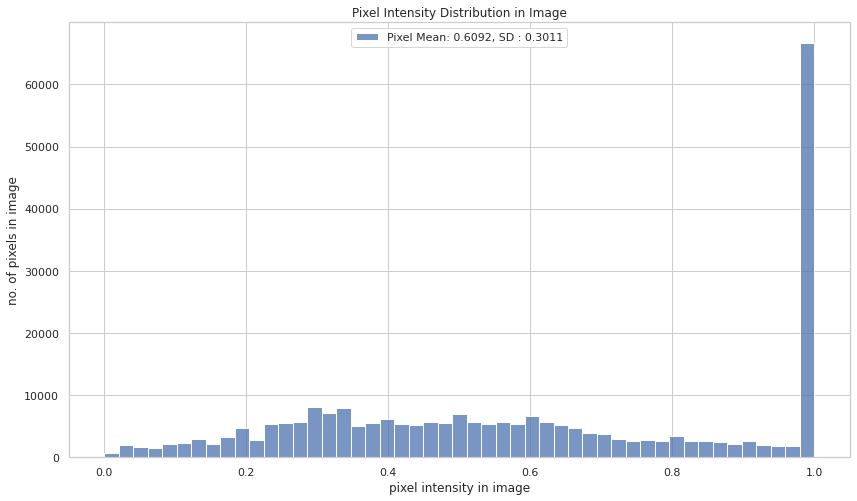

In [117]:
fig = plt.gcf()
fig.set_size_inches(14, 8)

sns.histplot(
    sample_img.ravel()
    , label = f'Pixel Mean: {np.mean(sample_img):.4f}, SD : {np.std(sample_img):.4f}'
    , kde=False )

plt.legend(loc='upper center')
plt.title('Pixel Intensity Distribution in Image')
plt.xlabel('pixel intensity in image')
plt.ylabel('no. of pixels in image')

## 3. Image Generator and Loader
***

### `xray_df` : Processed DataFrame

In [198]:
xray_df = xray_df.iloc[:10000] # Taking only 10000 samples

# Img index, patient ID modify
xray_df = xray_df.rename({'Image Index':'img_index'}, axis=1)
xray_df = xray_df.rename(columns={'Patient ID':'patient_id'})

print(xray_df.shape)
xray_df.head(3)

(10000, 18)


,img_index,patient_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_paths,target_vector
0,00000001_000.png,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000000...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


### Image paths, Target Vectors, Labels

In [199]:
# base_dir = os.path.dirname(xray_df['img_paths'].values[0])
# print(f'Directories Dict eg (values[0]):{base_dir}')
print('------------------------------------------------------------')

filenames = xray_df['img_paths'].values
print(f'Filenames : \n\n{filenames}\n\nDtype: {type(filenames)}')
print('------------------------------------------------------------')

classes = np.stack(xray_df['target_vector'].values)
print(f'Target Vector (stacked) :\n\n{classes}\n\nDtype: {type(classes)}')
print('------------------------------------------------------------')

cls_labels = xray_df.columns[2:-2]
print(f'Label Columns :\n\n{cls_labels} :\n\nDtype: {type(cls_labels)}')
print('------------------------------------------------------------')

------------------------------------------------------------
Filenames : 

['./Datasets/xray_preprocessed/images_001/00000001_000.png'
 './Datasets/xray_preprocessed/images_001/00000001_001.png'
 './Datasets/xray_preprocessed/images_001/00000001_002.png' ...
 './Datasets/xray_preprocessed/images_002/00002587_002.png'
 './Datasets/xray_preprocessed/images_002/00002587_003.png'
 './Datasets/xray_preprocessed/images_002/00002587_004.png']

Dtype: <class 'numpy.ndarray'>
------------------------------------------------------------
Target Vector (stacked) :

[[0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 [0.0 1.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

Dtype: <class 'numpy.ndarray'>
------------------------------------------------------------
Label Columns :

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mas

In [200]:
# Null check and Datatype
print('------------------------------------------------------------')
xray_df.info()
print('------------------------------------------------------------')

------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   img_index           10000 non-null  object 
 1   patient_id          10000 non-null  int64  
 2   Atelectasis         10000 non-null  float64
 3   Cardiomegaly        10000 non-null  float64
 4   Consolidation       10000 non-null  float64
 5   Edema               10000 non-null  float64
 6   Effusion            10000 non-null  float64
 7   Emphysema           10000 non-null  float64
 8   Fibrosis            10000 non-null  float64
 9   Hernia              10000 non-null  float64
 10  Infiltration        10000 non-null  float64
 11  Mass                10000 non-null  float64
 12  Nodule              10000 non-null  float64
 13  Pleural_Thickening  10000 non-null  float64
 14  Pneumonia           10000 non-null  float6

### Train-Dev-Test split (70%,10%,20%) : Dataframe Split

In [201]:
from sklearn.model_selection import train_test_split

train_and_dev_df, test_df = train_test_split(xray_df, test_size = 0.2, random_state = 111)
train_df, dev_df = train_test_split(train_and_dev_df, test_size = 0.16, random_state = 111)

print('------------------------------------------------------------')
print(f'Shape : Train-Set {train_df.shape}')
print(f'Shape : Dev-Set {dev_df.shape}')
print(f'Shape : Test-Set {test_df.shape}')
print('------------------------------------------------------------')

------------------------------------------------------------
Shape : Train-Set (6720, 18)
Shape : Dev-Set (1280, 18)
Shape : Test-Set (2000, 18)
------------------------------------------------------------


In [202]:
train_df.head(3)

,img_index,patient_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_paths,target_vector
3066,00000812_000.png,812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000008...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5151,00001373_055.png,1373,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_002/000013...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2360,00000618_010.png,618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./Datasets/xray_preprocessed/images_001/000006...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Check Data Leakage | Patient Overlap (Train, Valid set)

In [204]:
def check_leakage(df1, df2):
    
    pid_df1 = df1.patient_id.values
    pid_df2 = df2.patient_id.values
    
    # Uniqueness as set elements
    pid_df1_set = set(pid_df1)
    pid_df2_set = set(pid_df2)
    
    print('Unique Patients Train(df1): ', len(pid_df1_set))
    print('Unique Patients Dev(df2): ', len(pid_df2_set))
    
    # Overlaps -> Intersection of Set
    list_pid_overlaps = list(pid_df1_set.intersection(pid_df2_set))
    n_overlaps = len(list_pid_overlaps)
    
    print('No. of overlaps : ', n_overlaps)
    
    # Accumulate overlaps
    df1_overlap_idxs = []
    df2_overlap_idxs = []
    
    # append
    for idx in range (n_overlaps):
        df1_overlap_idxs.extend(df1.index[df1['patient_id'] == list_pid_overlaps[idx]].tolist())
        df2_overlap_idxs.extend(df2.index[df2['patient_id'] == list_pid_overlaps[idx]].tolist())
    
#     print(f'Overlaping indices in Set 1:\n{df1_overlap_idxs}')
#     print(f'\nOverlaping indices in Set 2:\n{df2_overlap_idxs}')
    
    # Drop the indices from one of the set (validation | train)
    print('\nDropping indices from df2 ....... \n')
    df2.drop(df2_overlap_idxs, inplace=True)
    
    #test overlap
    pid_df2 = df2.patient_id.values
    pid_df2_set = set(pid_df2)
    print('Unique patient df2:',len(pid_df2_set))
    
    list_pid_overlaps = list(pid_df1_set.intersection(pid_df2_set))
    n_overlap = len(list_pid_overlaps)

    print(f'There are {n_overlap} Overlaping PatientIDs in Df1 and Df2 sets')
    
# Run Once
    
check_leakage(train_df, dev_df)

Unique Patients Train(df1):  2129
Unique Patients Dev(df2):  184
No. of overlaps :  0

Dropping indices from df2 ....... 

Unique patient df2: 184
There are 0 Overlaping PatientIDs in Df1 and Df2 sets


### Image Generator

In [205]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator( featurewise_center=False
                             , samplewise_center=True
                             , featurewise_std_normalization=False
                             , samplewise_std_normalization=True
                             , zca_whitening=False
                             , zca_epsilon=1e-06
                             , rotation_range=5
                             , width_shift_range=0.1
                             , height_shift_range=0.05
                             , brightness_range=None
                             , shear_range=0.1
                             , zoom_range=0.15
                             , channel_shift_range=0.0
                             , fill_mode="reflect"
                             , cval=0.0
                             , horizontal_flip=True
                             , vertical_flip=False
                             , rescale=None
                             , preprocessing_function=None
                             , data_format=None
                             , validation_split=0.0
                             , dtype=None)

test_datagen=ImageDataGenerator(rescale=1./255.)

### Image loader from Dataframe

In [206]:
train_generator = data_gen.flow_from_dataframe( dataframe=train_df
                                              , directory=None
                                              , x_col="img_paths"
                                              , y_col=labels
                                              , weight_col=None
                                              , target_size=(256, 256)
                                              , color_mode="rgb"
                                              , classes=None
                                              , class_mode="raw"
                                              , batch_size=32
                                              , shuffle=True
                                              , seed=111
                                              , save_to_dir=None
                                              , save_prefix=""
                                              , save_format="png"
                                              , subset=None
                                              , interpolation="nearest"
                                              , validate_filenames=True )

# train_generator.y_col = np.stack(train_df['target_vector'].values)

dev_generator = data_gen.flow_from_dataframe( dataframe=dev_df
                                            , directory=None
                                            , x_col="img_paths"
                                            , y_col=labels
                                            , weight_col=None
                                            , target_size=(256, 256)
                                            , color_mode="rgb"
                                            , classes=None
                                            , class_mode="raw"
                                            , batch_size=32
                                            , shuffle=True
                                            , seed=111
                                            , save_to_dir=None
                                            , save_prefix=""
                                            , save_format="png"
                                            , subset=None
                                            , interpolation="nearest"
                                            , validate_filenames=True )

# dev_generator.y_col = np.stack(train_df['target_vector'].values)

test_generator = test_datagen.flow_from_dataframe( dataframe=test_df
                                                 , directory=None
                                                 , x_col="img_paths"
                                                 , y_col=labels
                                                 , batch_size=32
                                                 , color_mode="rgb"
                                                 , seed=111
                                                 , shuffle=False
                                                 , class_mode=None
                                                 , target_size=(256,256) )

Found 6720 validated image filenames.
Found 192 validated image filenames.
Found 2000 validated image filenames.


In [207]:
print( test_generator )
print( train_generator )

### Train generator Samples

  0%|          | 0/8 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [00:00<00:00, 78.19it/s]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


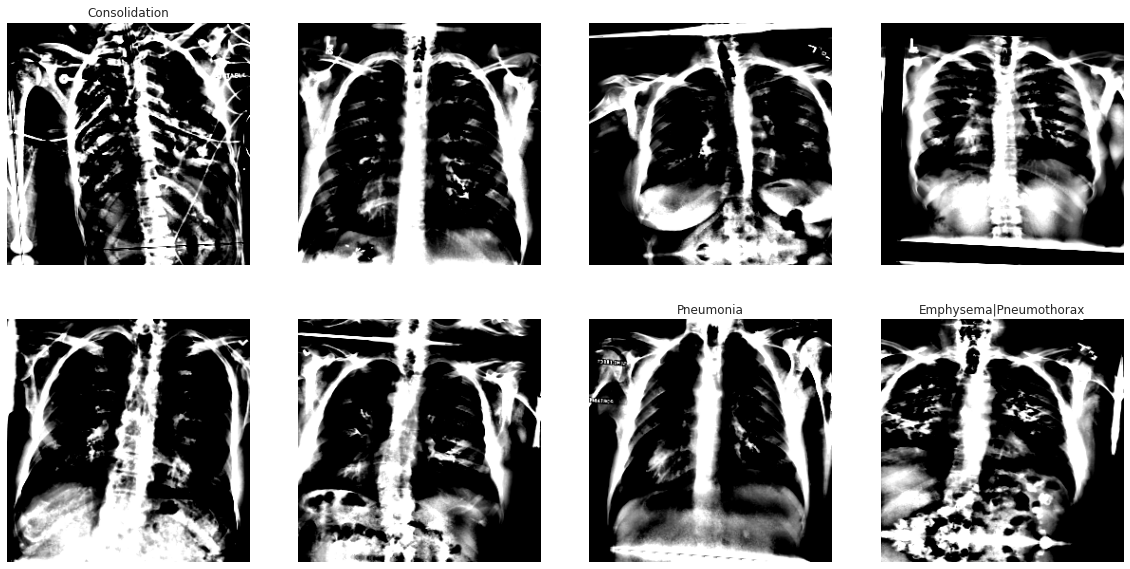

In [208]:
from tqdm import tqdm

def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return ''
    else:
        return '|'.join(ret_labels)
    
t_x, t_y = train_generator.__getitem__(0)

fig=plt.figure(figsize=(20, 10))
columns = 4; rows = 2 

for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(t_x[i-1], cmap = 'gray')
    plt.title(get_label(t_y[i-1]))
    plt.axis(False)
    fig.add_subplot

    
print(type(t_x))
print(type(t_y))

In [209]:
# fig, m_axs = plt.subplots(3, 4, figsize = (16, 16))

# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
#     c_ax.set_title(','.join([n_class for n_class, n_score in zip(labels, c_y) if n_score>0.5]))
#     c_ax.axis('off')

## Problem of Class-Imbalance

One of the main challange of datasets for medical diagnosis is the impact of `Class Imbalance` on the loss function. Since in the real world dataset there are more negative(healthy) examples than the positive ones, the model will be biased to emphasize `No Findings` examples while training. Example ( Regular Loss vs Weighted Loss) [[@Here]]() [Concepts: @Coursera(AI for medical Diagnosis)]

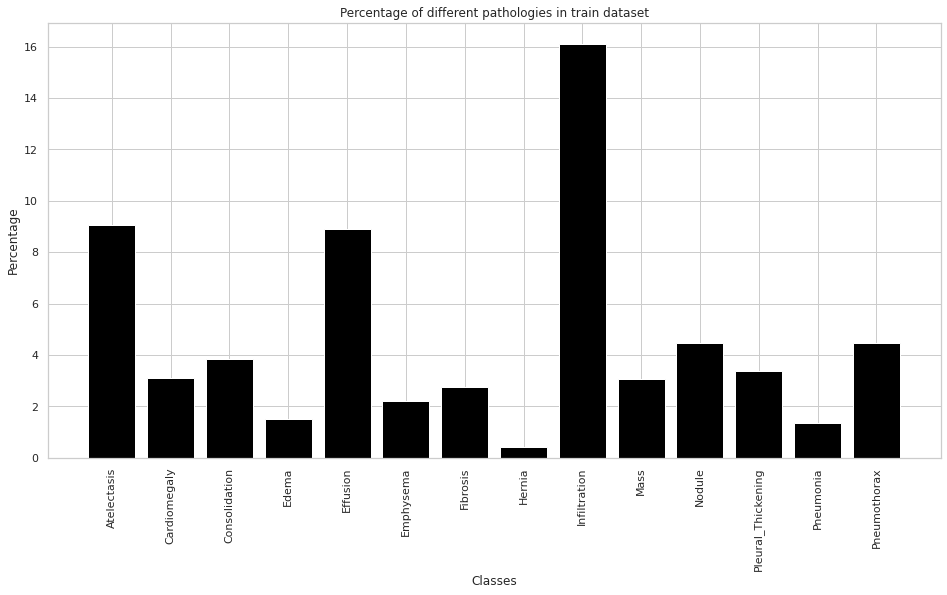

In [210]:
fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

plt.xticks(rotation = 90)
plt.bar(labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100, color='black')
plt.title('Percentage of different pathologies in train dataset')
plt.xlabel('Classes')
plt.ylabel('Percentage')
plt.show()

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

### Impact of class imbalance on loss function

The cross-entropy loss contribution from the $i^{th}$ training example:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

The cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

If there is a large imbalance with very few positive training cases, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

In [211]:
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

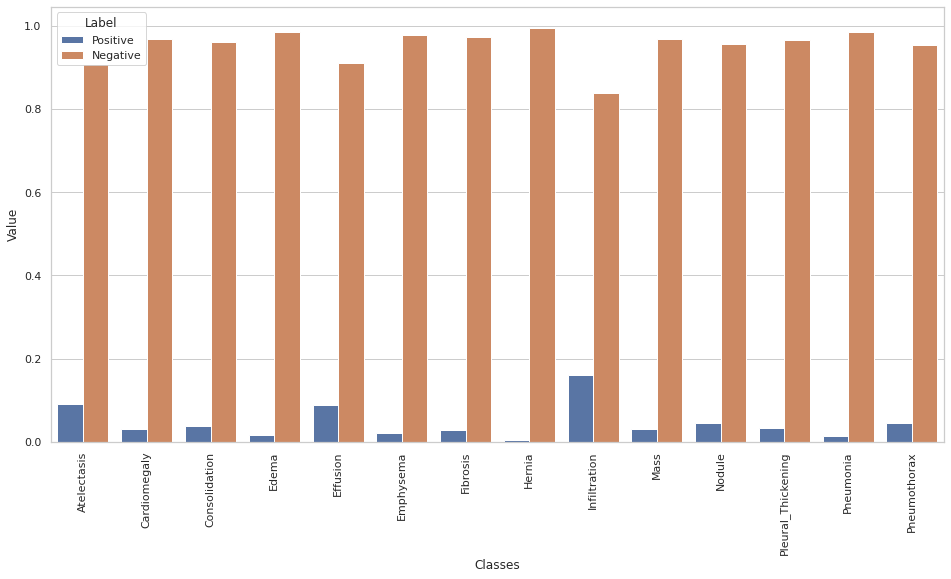

In [212]:
# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

data = pd.DataFrame({"Classes": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Classes": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

plt.xticks(rotation=90)
f = sns.barplot(x="Classes", y="Value", hue="Label" ,data=data)

The contributions from both cases should be equal which is not the case above. the equality can be achieved by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

For following condition to be true (equal contribution) 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

We can balance the contribution as below:

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

In [213]:
# positive and negative weights

pos_weights = freq_neg
neg_weights = freq_pos

pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
print('------------------------------------------------------------')
print(f'Positive Weights : \n\n{pos_weights}')
print(f'\n\nNegative Weights : \n\n{neg_weights}')
print('------------------------------------------------------------')

------------------------------------------------------------
Positive Weights : 

[0.909375   0.96889881 0.96160714 0.98482143 0.9108631  0.97797619
 0.97261905 0.99598214 0.83883929 0.96919643 0.95550595 0.96636905
 0.98645833 0.95535714]


Negative Weights : 

[0.090625   0.03110119 0.03839286 0.01517857 0.0891369  0.02202381
 0.02738095 0.00401786 0.16116071 0.03080357 0.04449405 0.03363095
 0.01354167 0.04464286]
------------------------------------------------------------


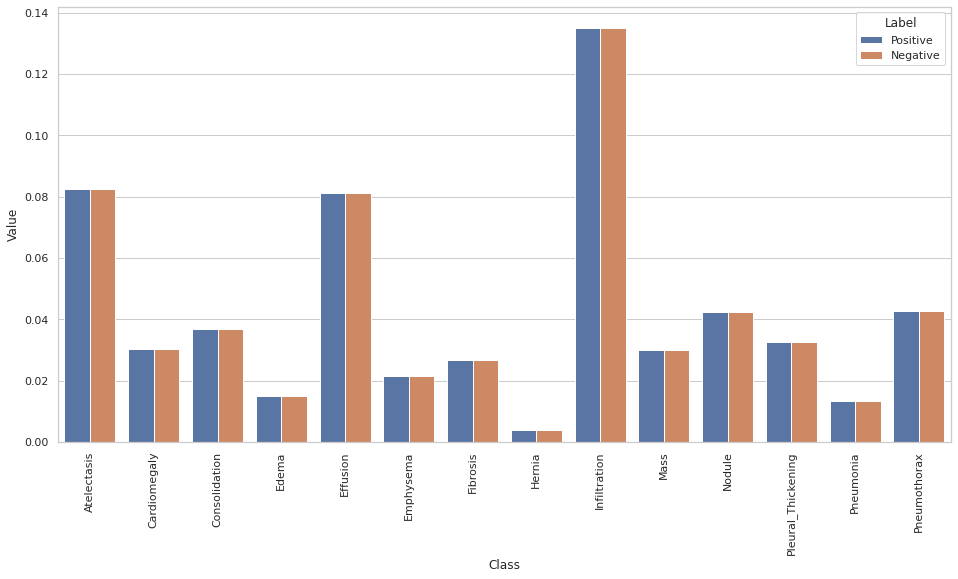

In [214]:
# Plot
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}  for l,v in enumerate(neg_contribution)], ignore_index=True)

fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

### Weighted Loss Instead of Binary Cross-Entropy Loss

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. 
After computing the weights, the final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [3]:
import Utils.loss_utils  as l_utils

# l_utils.get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

## Models

***

`Architectures inspired from CheXNet`[2.]

### Custom CNN

- Activation : ReLU
- Same Padding : Kernel size : (3x3)

**Input Img**

```
( 256,256, 3 )
```


**Block**
```
Conv2D -> Conv2D -> Conv2D -> BatchNorm -> Dropout -> MaxPooling(Pool_size = (2,2))
```

**Sequential Layers**

```
Block1 -> Block2 -> Block3 -> Block4 -> Block5 -> Block6 -> Block7 -> Flatten(1024) -> Dense(128) -> Output
```

**Output**

```
(14, Sigmoid)
```

In [216]:
from Model.Xnet import Xnet

model = Xnet(model2load='custom',
                    percent2retrain=0.1,
                    image_dimensions=(256,256,3),
                    n_classes=len(labels)).get_model()
model.summary()

# May need to install pydot and grapviz for plot_model

# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
dropout_42 (Dropout)         (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 128, 128, 64)     

### Densenet 121 (Pretrained with `imagenet`)

Densenet is a convolutional network where, for each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers.[1.]

- $l^{th}$ layer is connected to $(l+1), (l+2), ... L^{th}$ layers
- $(l+1)^{th}$ layer is connected to $(l+2), (l+3), ... L^{th}$ layers
- so on.

![](./assets/densenet.png)



**Densenet**:
- Alleviate the vanishing-gradient problem.
- Strengthen feature propagation.
- Encourage feature reuse.
- Substantially reduce the number of parameters.

In [217]:
from Model.Xnet import Xnet

model = Xnet(model2load='densenet121',
                    percent2retrain=0.1,
                    image_dimensions=(256,256,3),
                    n_classes=len(labels)).get_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten_8 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               33554944  
_________________________________________________________________
dropout_50 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 14)                7182      
Total params: 40,599,630
Trainable params: 34,496,590
Non-trainable params: 6,103,040
_________________________________________________________________


In [218]:
# [print(i.shape, i.dtype) for i in model.inputs]
# [print(o.shape, o.dtype) for o in model.outputs]
# [print(l.name, l.input_shape, l.dtype) for l in model.layers]

## Training
***

#### Choose The model ( Custom | Densenet 121(Percent to train(0-1) ))

**Options :**

- `custom` | `densenet121`

In [219]:
import time
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LambdaCallback

### Parameters

In [220]:
# Parameters
test_trained_model     = False
load_previous_weights  = False

# -----------------------------------------------
# #decrease resource usage:
# idle_time_on_batch = 0.1
# idle_time_on_epoch = 20
# -----------------------------------------------
train_steps = len(train_generator)
epochs = 50
batch_size = 32
image_shape = (256, 256, 3)
model_learn_rate = 0.001
model_architecture = 'custom'

### Train Model

x---------------- Creating Model ----------------x
x---------------- Training Model ----------------x
x---------------- Loading Model Wts. -------------x
x---------------- Optimization Init -------------x
x---------------- Compiling Model ---------------x
x---------------- Training Model -----------------x
Epoch 1/2
210/210 [==============================] - 1145s 5s/step - loss: 0.3049 - acc: 0.1159 - val_loss: 0.2060 - val_acc: 0.0260

Epoch 00001: val_loss improved from inf to 0.20601, saving model to model_weights.hdf5
Epoch 2/2
210/210 [==============================] - 1134s 5s/step - loss: 0.1998 - acc: 0.1674 - val_loss: 0.1442 - val_acc: 0.0625

Epoch 00002: val_loss improved from 0.20601 to 0.14420, saving model to model_weights.hdf5
x---------------- Loss and Accuracy ----------------x


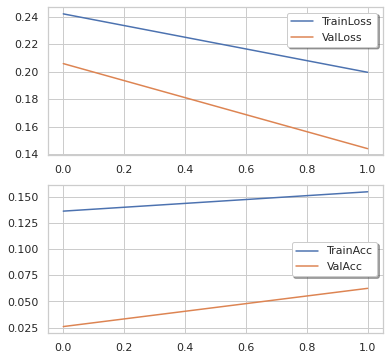

In [221]:
if not test_trained_model:
    
    # Recall the model
    print('x---------------- Creating Model ----------------x')
    model = Xnet(model2load=model_architecture,
                        percent2retrain=0.6,
                        image_dimensions=image_shape,
                        n_classes=14).get_model()
    
    # Load previous Model weights
    print('x---------------- Training Model ----------------x')
    if load_previous_weights == True:
        print('x---------------- Loading Model Wts. -------------x')
        model.load_weights("model_weights.hdf5")
        
    print('x---------------- Optimization Init -------------x')
    # Gradient Optimization
    optimizer = Adam(lr=model_learn_rate,
                     beta_1=0.9,
                     beta_2=0.999,
                     epsilon=1e-08,
                     decay=0.0,
                     amsgrad=False)
    
    print('x---------------- Compiling Model ---------------x')
    model.compile(optimizer=optimizer
                  , loss='binary_crossentropy'
#                   , loss=get_weighted_loss(pos_weights, neg_weights)
                  , metrics=['acc'])
    
    # Learning rate Decay
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=5,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00000001)
    
    # Early Stopping (In case model is starting to overfit )
    early_stop = EarlyStopping(monitor="val_loss",
                               mode="min",
                               patience=12)
    
    # Save model Checkpoint
    checkpoint = ModelCheckpoint('model_weights.hdf5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 save_weights_only=True)
    
    #sleep after each batch and epoch (prevent laptop from melting) (sleeps for x sec)(remove for faster training)
#     idle = LambdaCallback(on_epoch_end=lambda batch
#                           , logs: time.sleep(idle_time_on_epoch)
#                           , on_batch_end=lambda batch
#                           , logs: time.sleep(idle_time_on_batch))
    
    # save model to json file
    with open("model.json", "w") as json_model:
        json_model.write(model.to_json())
        
    # model.summary()
    
    print('x---------------- Training Model -----------------x')
    history = model.fit(train_generator,
                        steps_per_epoch=train_steps,
                        epochs=epochs,
                        validation_data=dev_generator,
                        max_queue_size=15,
                        workers=-1,
                        callbacks=[learning_rate_reduction, early_stop, checkpoint],
                    )

    
    print('\n\nx---------------- Loss  ----------------------x')
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax[0].plot(history.history['loss'], label="TrainLoss")
    ax[0].plot(history.history['val_loss'], label="ValLoss")
    ax[0].legend(loc='best', shadow=True)
    print('x---------------- Accuracy  ----------------------x')
    ax[1].plot(history.history['acc'], label="TrainAcc")
    ax[1].plot(history.history['val_acc'], label="ValAcc")
    ax[1].legend(loc='best', shadow=True)
    plt.show()



else: # if use_trained_model:
    
    print('x---------------- Loading Model ----------------x')
    from keras.models import model_from_json
    
    with open('model.json', 'r') as json_model:
        model = model_from_json(json_model.read())
        
    print('x----------------Loading Weights----------------x')
    model.load_weights("model_weights.hdf5")
    
    print('x---------------- Optimization Init ------------x')
    optimizer = Adam(lr=model_learn_rate
                     , beta_1=0.9
                     , beta_2=0.999
                     , epsilon=1e-08
                     , decay=0.0
                     , amsgrad=False)
    print('x---------------- Compiling Model ---------------x')
    model.compile(optimizer=optimizer
                  , loss='binary_crossentropy'
#                   , loss=get_weighted_loss(pos_weights, neg_weights)
                  , metrics=['acc'])
    print('x---------------- Ready 2 Use -------------------x')

## Evaluation
***

In [224]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 5s 73ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Test loss: 0.0
Test accuracy: 0.0


In [226]:
predict = model.predict(test_generator, steps = len(test_generator))

### ROC Curve

In [229]:
import Utils.img_utils as utils

auc_rocs = utils.get_roc_curve(labels, predict, test_generator)

Error in generating ROC curve for Atelectasis. Dataset lacks enough examples.
Error in generating ROC curve for Cardiomegaly. Dataset lacks enough examples.
Error in generating ROC curve for Consolidation. Dataset lacks enough examples.
Error in generating ROC curve for Edema. Dataset lacks enough examples.
Error in generating ROC curve for Effusion. Dataset lacks enough examples.
Error in generating ROC curve for Emphysema. Dataset lacks enough examples.
Error in generating ROC curve for Fibrosis. Dataset lacks enough examples.
Error in generating ROC curve for Hernia. Dataset lacks enough examples.
Error in generating ROC curve for Infiltration. Dataset lacks enough examples.
Error in generating ROC curve for Mass. Dataset lacks enough examples.
Error in generating ROC curve for Nodule. Dataset lacks enough examples.
Error in generating ROC curve for Pleural_Thickening. Dataset lacks enough examples.
Error in generating ROC curve for Pneumonia. Dataset lacks enough examples.
Error in

***